# Wine Classification

In [471]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

2.4.0-dev20200723


In [519]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [520]:
# Change to top directory of your Drive
import os
os.chdir('/content/gdrive/Shared drives/AI4ALL SFU NLP GROUP 3/WINE')

In [546]:
# Load data
df = pd.read_csv('winemag-data-130k-v2.csv')

In [547]:
df.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [592]:
# Get only the columns we want
wine_df = df[['description', 'variety']].copy()

In [595]:
wine_df

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,Riesling
129967,Citation is given as much as a decade of bottl...,Pinot Noir
129968,Well-drained gravel soil gives this wine its c...,Gewürztraminer
129969,"A dry style of Pinot Gris, this is crisp with ...",Pinot Gris


In [596]:
wine_df['variety'].value_counts()[:5]

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Name: variety, dtype: int64

In [597]:
topVarieties = wine_df['variety'].value_counts()[:5].index.tolist()

In [598]:
wine_df_short = wine_df[wine_df.variety.isin(topVarieties)].copy()

In [599]:
wine_df_short

,description,variety
4,"Much like the regular bottling from 2012, this...",Pinot Noir
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon
14,Building on 150 years and six generations of w...,Chardonnay
20,Ripe aromas of dark berries mingle with ample ...,Red Blend
...,...,...
129956,"The blend is 44% Merlot, 33% Cabernet Sauvigno...",Bordeaux-style Red Blend
129958,This blend of Cabernet Sauvignon-Merlot and Ca...,Bordeaux-style Red Blend
129960,"Fresh and fruity, this is full of red cherry f...",Pinot Noir
129963,"A bouquet of black cherry, tart cranberry and ...",Cabernet Sauvignon


In [600]:
wine_df_short['variety_num'] = wine_df_short['variety'].astype('category').cat.codes


In [601]:
wineNames = dict( enumerate(wine_df_short['variety'].astype('category').cat.categories ) )
wineNames

{0: 'Bordeaux-style Red Blend',
 1: 'Cabernet Sauvignon',
 2: 'Chardonnay',
 3: 'Pinot Noir',
 4: 'Red Blend'}

In [602]:
wine_df_short

,description,variety,variety_num
4,"Much like the regular bottling from 2012, this...",Pinot Noir,3
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon,1
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon,1
14,Building on 150 years and six generations of w...,Chardonnay,2
20,Ripe aromas of dark berries mingle with ample ...,Red Blend,4
...,...,...,...
129956,"The blend is 44% Merlot, 33% Cabernet Sauvigno...",Bordeaux-style Red Blend,0
129958,This blend of Cabernet Sauvignon-Merlot and Ca...,Bordeaux-style Red Blend,0
129960,"Fresh and fruity, this is full of red cherry f...",Pinot Noir,3
129963,"A bouquet of black cherry, tart cranberry and ...",Cabernet Sauvignon,1


In [603]:
# Split our data into training and test sets (80/20)
train_df, test_df = np.split(wine_df_short.sample(frac=1), [int(.8*len(wine_df_short))])

In [604]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = stopwords.words('english')
for i in topVarieties:
  stops.extend(i.lower().split(' '))
print(stops[-15:])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
["weren't", 'won', "won't", 'wouldn', "wouldn't", 'pinot', 'noir', 'chardonnay', 'cabernet', 'sauvignon', 'red', 'blend', 'bordeaux-style', 'red', 'blend']


In [605]:
def cleanText(text):
    # Remove new lines from the text
    text = text.replace("\n", " ")
    text = text.lower()
    text = text.split(' ')
    text = [w for w in text if not w in stops] 
    text = ' '.join(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [606]:
train_df['description'] = train_df['description'].apply(lambda x : cleanText(x))
test_df['description'] = test_df['description'].apply(lambda x : cleanText(x))

In [607]:
train_df

,description,variety,variety_num
28539,ruddy primary cherry berry notes persist nose ...,Red Blend,4
108506,brings lot flavor table relatively modest pric...,Pinot Noir,3
2198,aromas ripe black plum underbrush exotic spice...,Red Blend,4
30287,brambly blackberry cassis fruit dominates over...,Cabernet Sauvignon,1
75558,brilliant aromatics rise layers fruit mineral ...,Pinot Noir,3
...,...,...,...
80301,aged bottle bit sauvignon franc bordeaux grape...,Bordeaux-style Red Blend,0
16058,rr wines receive special packaging little tech...,Pinot Noir,3
43221,offers impenetrable blackness thick aromatic l...,Red Blend,4
14877,attractive aromas perfumed berry baking spice ...,Red Blend,4


In [608]:
X = train_df['description']
y = train_df['variety_num']

In [609]:
vocab_size = 20000
max_seq_length = 400

In [610]:
# Construct a tokenizer using Keras
X_tokenizer = text.Tokenizer(vocab_size)

In [611]:
# Fit the tokenizer on our text
X_tokenizer.fit_on_texts(list(X))

In [612]:
# Encode words in sentences as a list of integer sequences
X_tokenized = X_tokenizer.texts_to_sequences(X)

In [613]:
# Pad sentences to maximum sequence length
X_train_val = sequence.pad_sequences(X_tokenized, maxlen=max_seq_length)

In [568]:
# # Save our fitted tokenizer for future use
# with open('wine_tokenizer.pkl', 'wb') as f:
#     pickle.dump(X_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [569]:
# # Download the GloVe embeddings and unzip the file
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [614]:
# Load the pre-trained word vectors
embedding_dim = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [615]:
# Create embedding matrix for our neural network
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in X_tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

In [616]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(np.array(y))

'''
sigmoid:
0.88
1

softmax:
[0.10, 0.35, 0.55] = 1
2
[0, 0, 1]

'''


'\nsigmoid:\n0.88\n1\n\nsoftmax:\n[0.10, 0.35, 0.55] = 1\n2\n[0, 0, 1]\n\n'

In [617]:
# Hyperparameters
filters = 250
kernel_size = 3
hidden_dims = 300

In [618]:
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.1))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2,
                       strides=None,
                       padding='same',))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

In [619]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [620]:
# Number of samples processed before the model is updated
batch_size= 16
# Number of times we go through the entire dataset (forward and backward)
epochs = 3

In [621]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y, test_size=0.20)

In [629]:
# Fit the model
hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_val, y_val)
                 )

Epoch 1/3
2015/2015 [==============================] - 25s 13ms/step - loss: 0.8289 - accuracy: 0.6809 - val_loss: 0.6779 - val_accuracy: 0.7364
Epoch 2/3
2015/2015 [==============================] - 24s 12ms/step - loss: 0.6171 - accuracy: 0.7670 - val_loss: 0.6137 - val_accuracy: 0.7646
Epoch 3/3
2015/2015 [==============================] - 25s 12ms/step - loss: 0.5100 - accuracy: 0.8099 - val_loss: 0.6312 - val_accuracy: 0.7684


In [622]:
model = tf.keras.models.load_model('wine_cnn_5_wines.h5')

In [580]:
'''model.save('wine_cnn_5_wines.h5')
'''

"model.save('wine_cnn_5_wines.h5')\n"

In [623]:
X_test = test_df['description'].values
y_test = test_df['variety_num'].values
print(y_test[0:1])

[2]


In [624]:
# Encode words in sentences as a list of integer sequences
X_test_tokenized = X_tokenizer.texts_to_sequences(X_test)

In [625]:
# Pad sentences to maximum sequence length
X_test_val = sequence.pad_sequences(X_test_tokenized, maxlen=max_seq_length)

In [630]:
# y_pred = model.predict(X_test_val)
y_pred = np.argmax(model.predict(X_test_val), axis=-1)


In [585]:
(test_df.head(10).description).tolist()

['firstrelease winery founded napa valleys dennis cakebread sauvignon merlot franc seven hills vineyard shows notes tomato leaf chocolate cherry vanilla oak  new french american initially takes lead fruit flavors focused soft oak giving tannins slightly astringent feel',
 'many people châteaus named them caroline chanfreauphilippon runs part château lestage cru bourgeois rich structured wine concentrated ripe juicy attractive blackcurrant fruits typical vintage firm tannins tight structure drink wine ',
 ' vineyard s spring mountain estate cabernets require aging show best  dry tannic unrewarding due astringency acidity terrific heart blackberries minerals thats vast rich—indicative great growing conditions begin come ',
 'several producers finest vineyards including georganne flax olivet lane klopp offers complex notes smoky lavender licorice velvety texture underlies mouthcoating flavors blackberry jam pomegranate cardamom finishing tartly acidity',
 'big solid firm wine edge little 

[2 1 2 1 0 0 1 4 4 4]
[2 0 1 1 2 3 1 4 4 4]


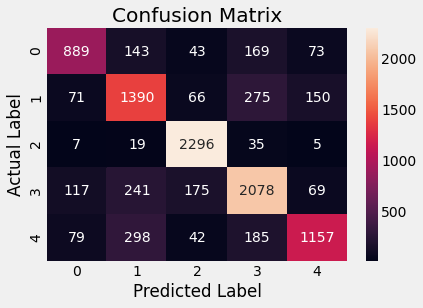

In [631]:

print(y_test[:10])
print(y_pred[:10])
cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)


In [632]:
accuracy_score(y_test, y_pred)

0.7754169976171564

In [ ]:
!pip install tf-nightly

In [633]:
print((test_df.head(10).description).tolist())
test_df.head(10)

['crunchy enticing freshness first pale almost translucent apples year underneath brings earth chalk stone yeast autolysis distinct expresses restrained chalky background imbues entire wine soft gentle fine creaminess elegant serious lasting', 'composed cherry cassis tobacco oak aromas elegant spot alert palate bold acidity moderate tannins lightly herbal plum cherry aromas earthy leafy green ruggedfeeling herbal finish suggests franc  cab sauvignon', 'good year chablis breath freshness impressive powerful  vintage still weight intensity chablis shows that extra dimension spice nuts tight appleskin structure leading fresh finish', 'topend dynamic moletto estate delivers impressive intensity extremely attractive notes black fruit toasted spice black stone nose slightly sweet smelling mouthfeel modern penetrating plush velvety', 'fresh fruity already drinkable tannins could soften further bright fruits acidity juicy enough already mineral texture fragrant aftertaste form balanced combina

,description,variety,variety_num
70570,crunchy enticing freshness first pale almost t...,Chardonnay,2
78722,composed cherry cassis tobacco oak aromas eleg...,Cabernet Sauvignon,1
126698,good year chablis breath freshness impressive ...,Chardonnay,2
107614,topend dynamic moletto estate delivers impress...,Cabernet Sauvignon,1
48406,fresh fruity already drinkable tannins could s...,Bordeaux-style Red Blend,0
38494,light fruity fragrant attractive crisp wine hi...,Bordeaux-style Red Blend,0
17101,juicy blackberry cherry leathery tannins chara...,Cabernet Sauvignon,1
25687,miracle grateful dead fans matured wine theres...,Red Blend,4
44288,labeled such petite sirah fruit young plummy p...,Red Blend,4
1509,gê one chiles perennial best blends mixes syra...,Red Blend,4


In [634]:
wineReview = input("Enter a description of what you want your wine to taste like: ")
while(wineReview != 'exit'):
  wineReview = cleanText(wineReview)
  wine_tokenized = X_tokenizer.texts_to_sequences([wineReview])
  wine_padded = sequence.pad_sequences(wine_tokenized[0:1], maxlen=max_seq_length)
  predictedWine = np.argmax(model.predict(wine_padded), axis=-1)
  print(wineNames[int(predictedWine)])
  wineReview = input("Enter a description of what you want your wine to taste like: ")

Enter a description of what you want your wine to taste like: apple and blackberry with some spice
Cabernet Sauvignon
Enter a description of what you want your wine to taste like: cherry and raspberry
Pinot Noir
Enter a description of what you want your wine to taste like: exit
